# Classification -- MNIST

In [94]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score,StratifiedKFold,cross_val_predict
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score
from sklearn.metrics import precision_recall_curve,roc_curve, roc_auc_score
from sklearn.base import clone,BaseEstimator
from sklearn.multiclass import OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier

In [16]:
%matplotlib inline

### MNIST Data

In [7]:
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [8]:
X, y = mnist['data'],mnist['target']
print X.shape, y.shape

(70000, 784) (70000,)


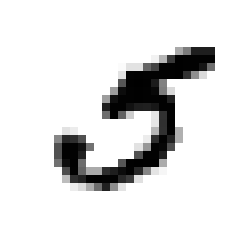

In [11]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, 
          interpolation='nearest')
plt.axis('off')
plt.show()

In [12]:
y[36000]

5.0

In [14]:
# The MNIST dataset has already been split into a training set (the fitst 60,000 images) 
# and a test set(the last 10,000 images)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [15]:
# but also need to shuffle the training set to guarantee that all cross-validation folds will be similar
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Training a Binary Classifier

In [22]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

##### SGD
SGD: Stochastic Gradient Descent classifier; This classifier has the advantage of being capable of handing very large datasets efficiently. SGD deals with training instance independently, one at a time, which also makes SGD well suited for online learning 

In [19]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

//anaconda/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [20]:
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

### Performance Measures

##### Measuring Accuracy Using Cross-Validation

In [24]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([ 0.9642 ,  0.94995,  0.96655])

In [36]:
# implement cross validation self, does roughly the same thing as cross_val_score
skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print (float(n_correct)/len(y_pred))

0.9642
0.94995
0.96655


In [42]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [43]:
# There are about 10% of the images are 5s, so if you always guess that an image is not a 5, 
# you will get an accuracy about 90%  
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.9118 ,  0.9057 ,  0.91145])

##### Confusion Matrix

In [39]:
# cross_val_predict returns the predictions made on each test fold
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53298,  1281],
       [ 1105,  4316]])

##### Precision and Recall

In [50]:
precision_score(y_train_5, y_train_pred)

0.77112738967303918

In [51]:
recall_score(y_train_5, y_train_pred)

0.79616306954436455

In [52]:
f1_score(y_train_5, y_train_pred)

0.78344527137411513

##### Precision/Recall tradeoff

In [53]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([ 14021.6439687])

In [58]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True], dtype=bool)

In [60]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False], dtype=bool)

In [62]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [64]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [69]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel("Threshold")
    plt.legend(loc='upper left')
    plt.ylim([0, 1])

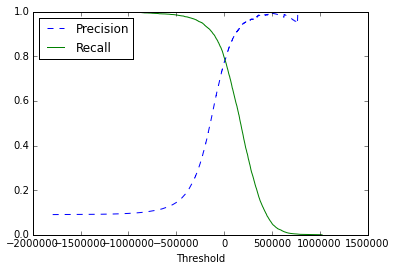

In [70]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [71]:
y_train_pred_90 = (y_scores > 70000)

In [72]:
precision_score(y_train_5, y_train_pred_90)

0.86172668513388739

In [73]:
recall_score(y_train_5, y_train_pred_90)

0.6886183361003505

##### The ROC Curve
ROC: Receiver Operating Characteristic. The ROC curve plots the *true positive rate(TPR)* against the *false positive rate(FPR)*. 

TPR is equal to recall, and FPR is the ratio of negative instance that is incorrectly classified as positive. 
TPR=TP/(TP+FN)=Recall, FPR=FP/(FP+TN)

In [75]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

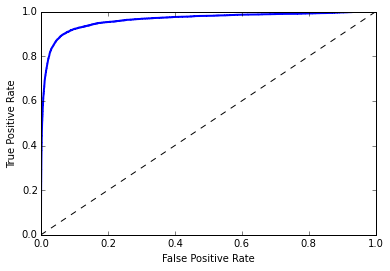

In [76]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
plot_roc_curve(fpr, tpr)
plt.show()

In [79]:
roc_auc_score(y_train_5, y_scores)

0.96317767800989063

### Multiclass Classification

In [80]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([ 5.])

In [81]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-168012.11897818, -348511.08620714, -300185.93373003,
        -193970.63269057, -245929.44587187,   14021.6439687 ,
        -585551.37606615, -299767.67092103, -599680.96394789,
        -516428.92818168]])

In [82]:
np.argmax(some_digit_scores)

5

In [83]:
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [86]:
sgd_clf.classes_[np.argmax(some_digit_scores)]

5.0

In [88]:
# force sklearn to use one-versus-one 
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([ 5.])

In [89]:
len(ovo_clf.estimators_)

45

In [91]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([ 0.86232753,  0.88089404,  0.83372506])

In [93]:
cross_val_score(ovo_clf, X_train, y_train, cv=3, scoring='accuracy')

array([ 0.91081784,  0.90054503,  0.9079862 ])

In [95]:
forest_clf = RandomForestClassifier()
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 5.])

In [96]:
forest_clf.predict_proba([some_digit])

array([[ 0. ,  0. ,  0.1,  0.2,  0. ,  0.7,  0. ,  0. ,  0. ,  0. ]])

In [97]:
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring='accuracy')

array([ 0.94406119,  0.94139707,  0.94014102])

### Error Analysis

In [99]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5712,    0,   25,   11,   14,   24,   57,    3,   51,   26],
       [   2, 6268,   35,   29,   11,   37,   24,   12,  296,   28],
       [  59,   66, 5064,  122,   76,   38,  165,   59,  275,   34],
       [  53,   51,  200, 5008,   26,  251,   49,   52,  207,  234],
       [  13,   13,   29,   12, 5236,   18,   74,    5,   82,  360],
       [  98,   27,   43,  244,  118, 4149,  163,   13,  383,  183],
       [  38,    8,   66,    6,   31,   84, 5627,    2,   51,    5],
       [  37,   23,   77,   54,  138,   20,    8, 5354,   72,  482],
       [  65,   86,  106,  203,   97,  292,   66,   22, 4642,  272],
       [  37,   18,   29,   84,  616,   78,   12,  330,  266, 4479]])

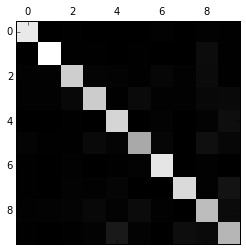

In [100]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

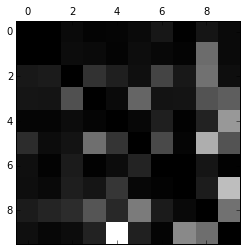

In [105]:
row_sums = conf_mx.sum(axis=1, keepdims=True) * 1.0
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()